# ***Katsaidonis Nikolaos 03121868***

# **School of Electrical and Computer Engineering - National Technical University of Athens**


# **First Laboratory Exercise - Image and Video Technology and Analysis**

# **Laplacian Pyramids**


***Theoretical Part***

**Question 1: How does the value of α affect the Gaussian pyramid?**

The parameter α defines the shape of the kernel used for low-pass filtering in the construction of the Gaussian pyramid. For α = 0.3 and α = 0.4, the weighting function resembles a Gaussian function. As α increases towards 0.5 or 0.6, the shape becomes sharper or more triangular. As mentioned in the paper, for α = 0.6 the levels of the Gaussian pyramid appear crisper, as edges and details are more pronounced. For smaller values of α, the filter approximates a Gaussian more closely, resulting in a blurrier image.

**Question 2: What is entropy? Calculate the maximum entropy value a grayscale image can have.**

Entropy generally measures the amount of information or the uncertainty in a dataset. In this context, it represents the minimum number of bits per pixel needed to encode an image. Specifically, entropy is defined as:  
**H = – Σ [f(i) * log₂(f(i))]**,  
where f(i) is the probability or frequency of occurrence of gray level i (with i ranging from 0 to 255).

The maximum entropy, i.e., the highest uncertainty, occurs when all gray levels are equally probable (1/256). Substituting this into the formula yields a maximum entropy of 8 bits/pixel.

**Question 3: How does the choice of bin size affect quantization results?**

During quantization, pixel values are grouped into bins of size n. Each pixel value is replaced by the median of the bin it falls into. Quantization can reduce entropy, while introducing image changes that may not be perceptible to the human eye. A larger bin size means that more pixel values fall into the same bin, which increases quantization errors, as many pixels will receive the same quantized value (the bin’s median). However, this reduces the number of bits needed for storage. Conversely, a smaller bin size results in finer quantization (lower error), better image quality compared to the original, but at the cost of more bits required for representation.

**Question 4: How is quantization affected by the number of pyramid levels?**

As we move to higher levels in the pyramid, we observe that the quantized images exhibit decreasing entropy H. Furthermore, the bin size at each level is chosen by increasing n until image degradation becomes just barely perceptible when viewed from a distance. Thus, bin size is smaller at higher pyramid levels (where spatial frequencies are lower). The human visual system is quite sensitive to low and medium spatial frequencies, but not to high frequencies. As we ascend the pyramid levels, the frequency content of the image decreases due to repeated low-pass filtering. This increased visual sensitivity means that more quantization levels (i.e., smaller bin size) must be used at higher levels of the pyramid, as any error becomes more noticeable and must be minimized.


# Laboratory Part


**Α. Algorithm Implementation**

In [ ]:
# 1) h = GKernel(a): creates a Generating Kernel based on the parameter 'a'

import numpy as np

def GKernel(a):
  w = np.array([1/4 - a/2, 1/4, a, 1/4, 1/4 - a/2])
  h = np.outer(w, w)  # external product to get 5x5 kernel
  return h


In [ ]:
# 2) function I_out = GREDUCE(I, h):
from scipy import signal
"""
In the following function, we want to implement the REDUCE() function from the paper (page 533).
Essentially, this involves convolving the image with the generated kernel,
followed by downsampling every 2 pixels.
"""

def GREDUCE(I, h):
  # If the image is grayscale (2D)
  if I.ndim == 2:
    # Convolution with h kernel
    conv_image = signal.convolve2d(I, h, mode="same", boundary="symm")  # clip() limits the image to 0-255, mode='same' keeps input-output size equal, boundary handles edge pixels
    # Downsampling
    downsampled_image = conv_image[::2, ::2]
    I_out = downsampled_image
    return I_out

  # If the image is color (3D)
  elif I.ndim == 3:
    I = np.clip(I, 0, 255).astype(np.float32)
    channels = []
    for c in range(I.shape[2]):
      conv_image = signal.convolve2d(I[:, :, c], h, mode="same", boundary="symm")
      downsampled_image = conv_image[::2, ::2]
      channels.append(downsampled_image)
    # I_out = np.stack(channels, axis=2)
    I_out = np.stack(channels, axis=0).transpose(1, 2, 0)
    return I_out


Πειραματιζόμενοι με την τιμή του a, καταλήγουμε στο ότι όσο μειώνεται το a τόσο πιο blur γίνεται η εικόνα.

In [ ]:
# 3) G = GPyramid(I, a, depth): takes an image I as input,
# the parameter 'a', and the desired pyramid depth 'depth',
# and returns the Gaussian pyramid and stores it.

def GPyramid(I, a=0.5, depth=5):
  I = np.clip(I, 0, 255).astype(np.float32)
  gauss_pyramid = [I]  # First level contains the original image

  # Creating the kernel
  kernel = GKernel(a)

  # Constructing the pyramid
  for i in range(depth):
    g_i = gauss_pyramid[i]
    g_reduced = GREDUCE(g_i, kernel)
    gauss_pyramid.append(g_reduced)

  G = gauss_pyramid
  return G


In [ ]:
# 4) Function I_out = GEXPAND(I, h): according to equation (2) (page 534 of the paper).

"""
EXPAND() is essentially the inverse of REDUCE,
i.e., upsampling.
"""

def GEXPAND(I, h):

    # Image shape
    if I.ndim == 2:
      rows, cols = I.shape

      # We want to interpolate, so the final image will have twice the size of the input
      # We insert a pixel between the existing pixels, so nothing is added at the end
      # hence the "-1"
      output_rows = 2 * rows
      output_cols = 2 * cols

      # Upsampled image
      I_expanded = np.zeros((output_rows, output_cols), dtype=I.dtype)

      # Place the values of I at the even indices of the new array
      I_expanded[::2, ::2] = I

      # Apply convolution with the kernel and multiply by 4 as stated in the paper
      I_out = 4 * signal.convolve2d(I_expanded, h, mode='same', boundary='symm')
      # After convolution, the empty pixels will be filled based on their neighbors

      return I_out

    elif I.ndim == 3:
      I = np.clip(I, 0, 255).astype(np.float32)
      rows, cols, channels = I.shape
      output_rows = 2 * rows
      output_cols = 2 * cols

      expanded_channels = []
      for c in range(channels):
        I_expanded = np.zeros((output_rows, output_cols), dtype=I.dtype)
        I_expanded[::2, ::2] = I[:, :, c]
        conv = 4 * signal.convolve2d(I_expanded, h, mode='same', boundary='symm')
        expanded_channels.append(conv)

      # I_out = np.stack(expanded_channels, axis=2)
      I_out = np.stack(expanded_channels, axis=0).transpose(1, 2, 0)
      return I_out


In [ ]:
# 5) L = LPyramid(I, a, depth): returns the Laplacian pyramid of the image I
# (uses the GPyramid function)

def LPyramid(I, a=0.5, depth=5):
  # Gaussian pyramid
  G = GPyramid(I, a, depth)  # list that contains the Gaussian levels
  # Kernel
  kernel = GKernel(a)
  laplace_pyramid = []

  for i in range(len(G) - 1):
    expanded = GEXPAND(G[i + 1], kernel)
    # If the dimensions do not match exactly (e.g., due to odd image size), we crop
    if expanded.ndim == 2:
      expanded = expanded[0:G[i].shape[0], 0:G[i].shape[1]]
    else:
      expanded = expanded[0:G[i].shape[0], 0:G[i].shape[1], :]
    laplace = G[i] - expanded
    laplace_pyramid.append(laplace)

  # The last level of the Laplacian pyramid is the last level of the Gaussian pyramid
  laplace_pyramid.append(G[-1])
  L = laplace_pyramid
  return L


In [ ]:
# 6) I_out = L_Pyramid_Decode(L, a): returns the decoded image I_out,
# taking as input the Laplacian pyramid L and the parameter 'a' used to create it

def L_Pyramid_Decode(L, a=0.5):
  # We will use the recursive formula g_l = L_l + Expanded(g_l+1)
  result = L[-1]  # this is the same as the last level of the Gaussian pyramid
  kernel = GKernel(a)
  for i in range(len(L) - 2, -1, -1):  # descending order down to i = 0
    expanded = GEXPAND(result, kernel)
    # Crop to match the dimensions of level L[i]
    expanded = expanded[:L[i].shape[0], :L[i].shape[1]] if expanded.ndim == 2 else expanded[:L[i].shape[0], :L[i].shape[1], :]

    result = L[i] + expanded

  I_out = result

  return I_out


In [ ]:
# 7) L_Quantization, according to equation (5) (page 538 of the paper).

"""
Using the equation (m - 0.5)*n < L(i,j) ≤ (m + 0.5)*n, we find m.
For each level, each pixel L(i,j) is quantized as:
C(i,j) = m * n, where m = round( L(i,j) / n )

We also handle the case where n is a list, meaning we use different bin sizes for each level.
According to the paper, higher pyramid levels (with lower frequencies) require smaller bin sizes.
"""

def L_Quantization(L, n):
    quantized_levels = []

    # If n is a single number, use the same bin size for all levels
    if isinstance(n, (int, float)):
        n = [n] * len(L)

    # Ensure the list n has the same length as the number of pyramid levels
    assert len(n) == len(L), "The length of list n must match the number of levels in the Laplacian pyramid."

    for level, bin_size in zip(L, n):
        m = np.round(level / bin_size)
        quantized_level = m * bin_size
        quantized_levels.append(quantized_level)

    return quantized_levels


**B. Testing the algorithm**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import cv2
import matplotlib.pyplot as plt
from skimage import data
from skimage import io

# Load the "camera" image (already grayscale, i.e., 2D)
camera = data.camera()

# Load the "lena" image
image_path = '/content/drive/MyDrive/Image_Video_Lab1/lena.png'
lena = cv2.imread(image_path)
lena = cv2.cvtColor(lena, cv2.COLOR_BGR2RGB)
lena = np.clip(lena, 0, 255).astype(np.float32)


Mounted at /content/drive


In [8]:
print(lena.shape)

(512, 512, 3)


Gaussian pyramid levels for camera and lena:



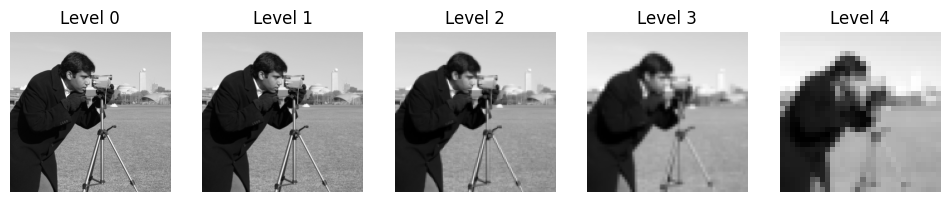

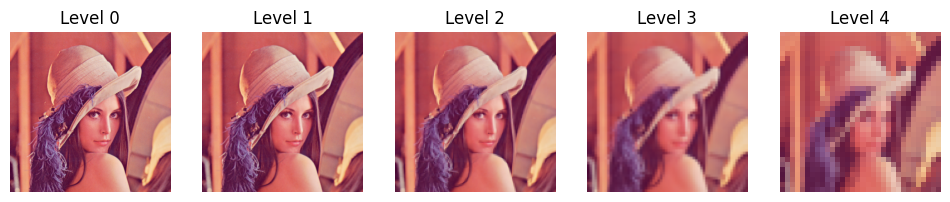

In [ ]:
# Gaussian pyramid
camera_gaussian_pyramid = GPyramid(camera, a=0.5, depth=5)
lena_gaussian_pyramid = GPyramid(lena, a=0.5, depth=5)

print("Gaussian pyramid levels for camera and lena:\n")

plt.figure(figsize=(12, 6))
for i in range(5):
  plt.subplot(1, 5, i + 1)
  plt.imshow(camera_gaussian_pyramid[i], cmap='gray')
  plt.title(f'Level {i}')
  plt.axis('off')

plt.figure(figsize=(12, 6))
lena_gaussian_pyramid_show = []
for i in range(5):
  plt.subplot(1, 5, i + 1)
  lena_gaussian_pyramid_show.append(np.clip(lena_gaussian_pyramid[i], 0, 255).astype(np.uint8))
  plt.imshow(lena_gaussian_pyramid_show[i])
  plt.title(f'Level {i}')
  plt.axis('off')

plt.show()


In [10]:
print(camera_gaussian_pyramid[0].shape)
print(camera_gaussian_pyramid[1].shape)
print(camera_gaussian_pyramid[2].shape)
print(camera_gaussian_pyramid[3].shape)
print(camera_gaussian_pyramid[4].shape)



(512, 512)
(256, 256)
(128, 128)
(64, 64)
(32, 32)


We observe that as the pyramid levels increase, the image becomes progressively more blurred, losing significant detail. This is expected, as what we are doing is downsampling the image after applying the kernel.


Laplacian pyramid levels for camera and lena:



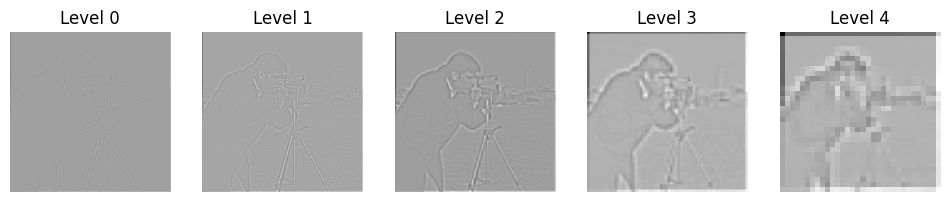

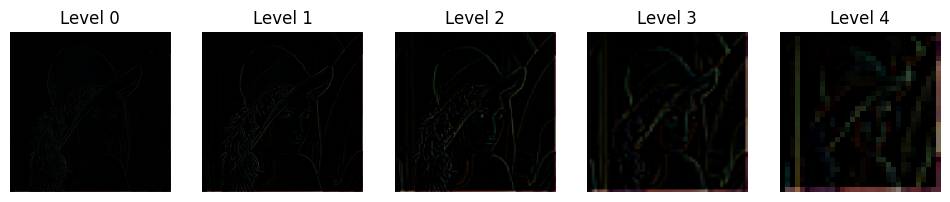

In [18]:
#Laplacian pyramid
camera_laplacian_pyramid = LPyramid(camera, a=0.5, depth=5)
lena_laplacian_pyramid = LPyramid(lena, a=0.5, depth=5)

print("Laplacian pyramid levels for camera and lena:\n")
plt.figure(figsize=(12,6))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(camera_laplacian_pyramid[i], cmap='gray')
  plt.title(f'Level {i}')
  plt.axis('off')


plt.figure(figsize=(12,6))
lena_laplacian_pyramid_show = []
for i in range(5):
  plt.subplot(1,5,i+1)
  lena_laplacian_pyramid_show.append(np.clip(lena_laplacian_pyramid[i], 0, 255).astype(np.uint8))
  plt.imshow(lena_laplacian_pyramid_show[i])
  plt.title(f'Level {i}')
  plt.axis('off')


plt.show()




At each level of the Laplacian pyramid, we subtract the expanded (interpolated) Gaussian of the next level from the current Gaussian level. In this way, as we move up the pyramid, we obtain higher quality and more detailed features.


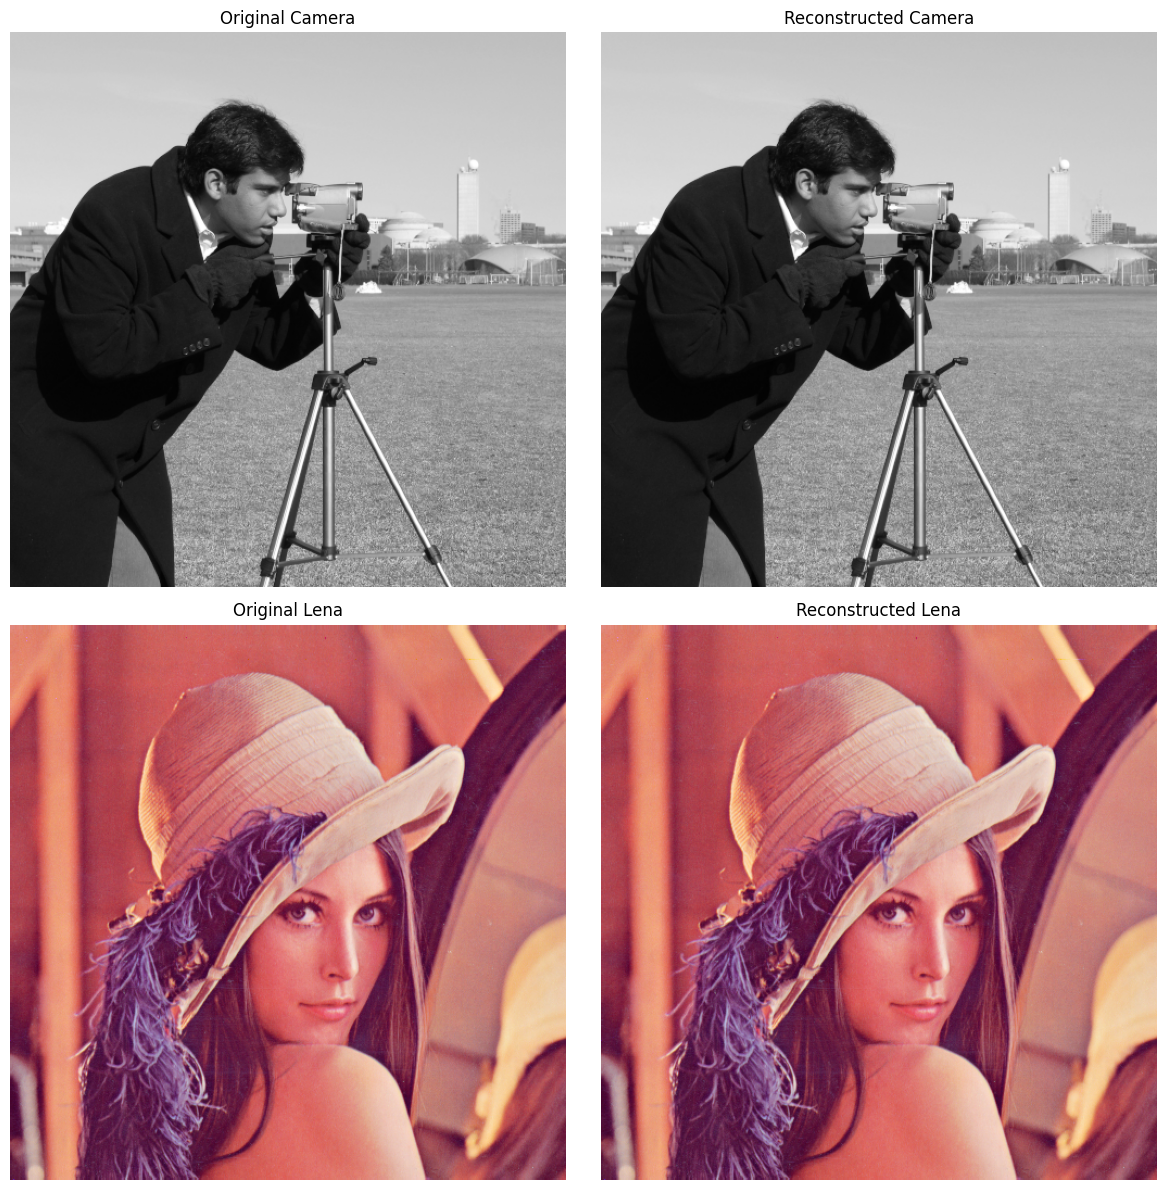

In [19]:
#Decoded image
reconstructed_camera = L_Pyramid_Decode(camera_laplacian_pyramid, a=0.5)
reconstructed_lena = L_Pyramid_Decode(lena_laplacian_pyramid, a=0.5)


plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.imshow(camera, cmap='gray')
plt.title("Original Camera")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(reconstructed_camera, cmap='gray')
plt.title("Reconstructed Camera")
plt.axis('off')

plt.subplot(2, 2, 3)
lena = np.clip(lena, 0, 255).astype(np.uint8)
plt.imshow(lena)
plt.title("Original Lena")
plt.axis('off')

plt.subplot(2, 2, 4)
reconstructed_lena = np.clip(reconstructed_lena, 0, 255).astype(np.uint8)
plt.imshow(reconstructed_lena)
plt.title("Reconstructed Lena")
plt.axis('off')

plt.tight_layout()
plt.show()





Η αποκωδικοποιημενη εικόνα έχει μη αντιληπτές διαφορές όπως βλέπουμε.

Quantized Laplacian pyramid levels for camera and lena:



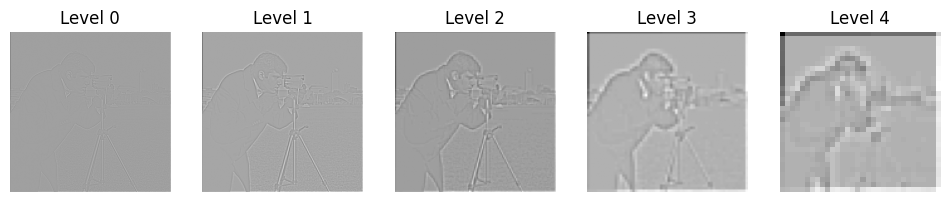

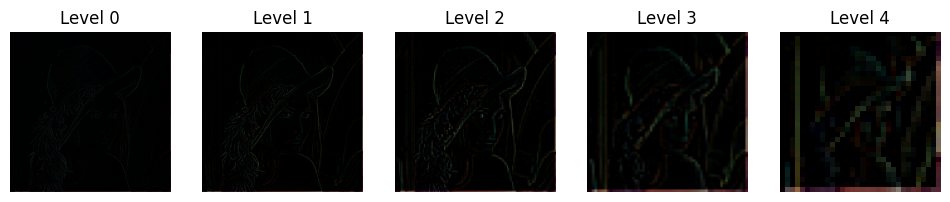

In [20]:
#Quantized laplacian pyramid

quantized_camera_laplacian_pyramid = L_Quantization(camera_laplacian_pyramid, n=5)
quantized_lena_laplacian_pyramid = L_Quantization(lena_laplacian_pyramid, n=5)


print("Quantized Laplacian pyramid levels for camera and lena:\n")
plt.figure(figsize=(12,6))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(quantized_camera_laplacian_pyramid[i], cmap='gray')
  plt.title(f'Level {i}')
  plt.axis('off')


plt.figure(figsize=(12,6))
quantized_lena_laplacian_pyramid_show = []
for i in range(5):
  plt.subplot(1,5,i+1)
  quantized_lena_laplacian_pyramid_show.append(np.clip(quantized_lena_laplacian_pyramid[i], 0, 255).astype(np.uint8))
  plt.imshow(quantized_lena_laplacian_pyramid_show[i])
  plt.title(f'Level {i}')
  plt.axis('off')


plt.show()





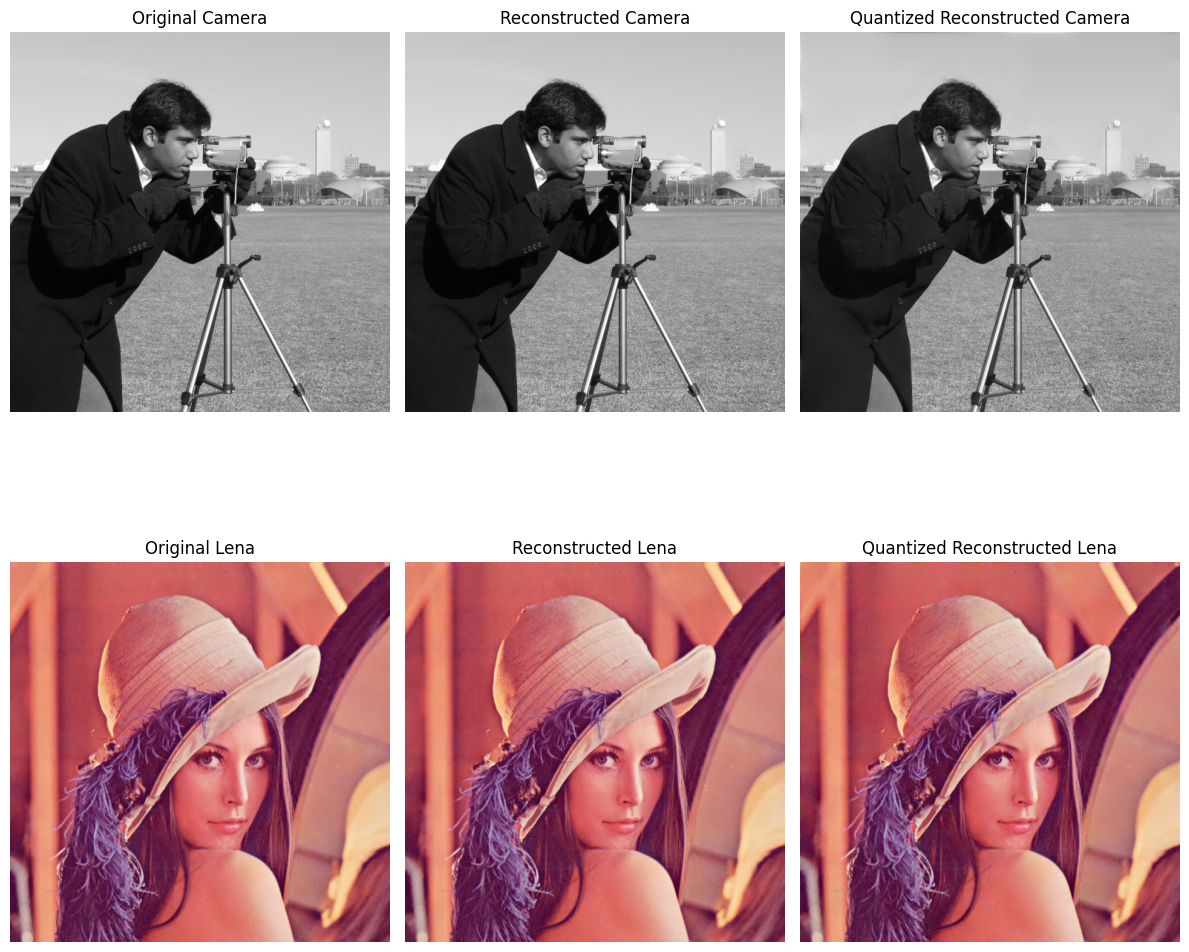

In [21]:
#Quantized reconstructed image

quantized_camera_reconstructed = L_Pyramid_Decode(quantized_camera_laplacian_pyramid, a=0.5)
quantized_lena_reconstructed = L_Pyramid_Decode(quantized_lena_laplacian_pyramid, a=0.5)

plt.figure(figsize=(12, 12))

plt.subplot(2, 3, 1)
plt.imshow(camera, cmap='gray')
plt.title("Original Camera")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(reconstructed_camera, cmap='gray')
plt.title("Reconstructed Camera")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(quantized_camera_reconstructed, cmap='gray')
plt.title("Quantized Reconstructed Camera")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(lena)
plt.title("Original Lena")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(reconstructed_lena)
plt.title("Reconstructed Lena")
plt.axis('off')

plt.subplot(2, 3, 6)
quantized_lena_reconstructed = np.clip(quantized_lena_reconstructed, 0, 255).astype(np.uint8)
plt.imshow(quantized_lena_reconstructed)
plt.title("Quantized Reconstructed Lena")
plt.axis('off')

plt.tight_layout()
plt.show()



The quantized-decoded image is slightly visually worse than the decoded image. This is due to the reduction in entropy, which results from replacing pixel values with quantized values. That is, many pixels that originally had similar (but distinct) values now share the same value, leading to a loss of image detail.


# Different a values


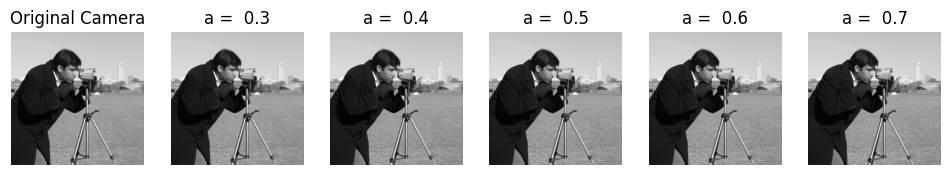

In [22]:
#Camera image

a_list = [0.3, 0.4, 0.5, 0.6, 0.7]
camera_pyramid_list1 = []
decoded_list1 = []

#Produce pyramids for each a
for a in a_list:
   camera_pyramid = LPyramid(camera, a, depth=5)
   camera_pyramid_list1.append(camera_pyramid)

# Decode each pyramid with its corresponding a value
for i, pyramid in enumerate(camera_pyramid_list1):
    a = a_list[i]
    decoded_image = L_Pyramid_Decode(pyramid, a)
    decoded_list1.append(decoded_image)

#Plotting the images
plt.figure(figsize=(12, 12))
plt.subplot(1,len(a_list)+1,1)
plt.imshow(camera, cmap='gray')
plt.title(f"Original Camera")
plt.axis('off')

for i in range (len(decoded_list1)):
  plt.subplot(1,len(a_list)+1,i+2)
  plt.imshow(decoded_list1[i], cmap='gray')
  plt.title(f"a =  {a_list[i]}")
  plt.axis('off')

We observe a slight difference as the parameter 'a' increases. For a more accurate comparison, we calculate the mean squared error.


In [ ]:
def calculate_mse(original, decoded):
    return np.mean((original - decoded) ** 2)

for i, decoded_image in enumerate(decoded_list1):
    mse = calculate_mse(camera, decoded_image)
    print(f"For a = {a_list[i]}: MSE = {mse}")


Για a = 0.3: MSE = 1.364273101191463e-31
Για a = 0.4: MSE = 3.088604824017196e-31
Για a = 0.5: MSE = 0.0
Για a = 0.6: MSE = 6.774346672319904e-30
Για a = 0.7: MSE = 2.118017024865275e-28


Βλέπουμε ότι το μικρότερο σφάλμα το λαμβάνουμε για a=0.5.

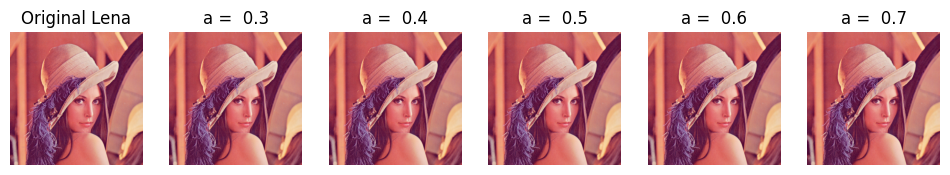

In [24]:
#Lena image

a_list = [0.3, 0.4, 0.5, 0.6, 0.7]
lena_pyramid_list1 = []
decoded_list2 = []

#Produce pyramids for each a
for a in a_list:
   lena_pyramid = LPyramid(lena, a, depth=5)
   lena_pyramid_list1.append(lena_pyramid)

# Decode each pyramid with its corresponding a value
for i, pyramid in enumerate(lena_pyramid_list1):
    a = a_list[i]
    decoded_image = L_Pyramid_Decode(pyramid, a)
    decoded_list2.append(decoded_image)

#Plotting the images
plt.figure(figsize=(12, 12))
plt.subplot(1,len(a_list)+1,1)
plt.imshow(lena)
plt.title(f"Original Lena")
plt.axis('off')

decoded_list2_show = []
for i in range (len(decoded_list2)):
  plt.subplot(1,len(a_list)+1,i+2)
  decoded_list2_show.append(np.clip(decoded_list2[i], 0, 255).astype(np.uint8))
  plt.imshow(decoded_list2_show[i])
  plt.title(f"a =  {a_list[i]}")
  plt.axis('off')

In [ ]:
def calculate_mse(original, decoded):
    return np.mean((original - decoded) ** 2)

for i, decoded_image in enumerate(decoded_list2):
    mse = calculate_mse(lena, decoded_image)
    print(f"For a = {a_list[i]}: MSE = {mse}")


Για a = 0.3: MSE = 0.0
Για a = 0.4: MSE = 0.0
Για a = 0.5: MSE = 0.0
Για a = 0.6: MSE = 3.99837570210627e-17
Για a = 0.7: MSE = 1.522344768483076e-13


# Different depth values

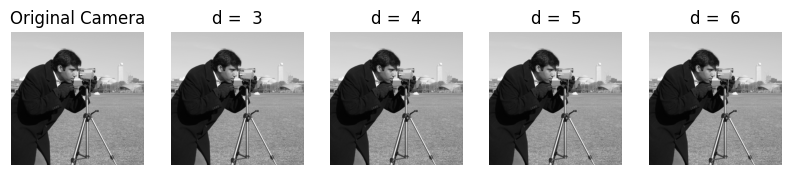

In [26]:
#Camera image

depth_list = [3, 4, 5, 6]
camera_pyramid_list2 = []
decoded_list3 = []

#Produce pyramids for each a
for depth in depth_list:
   camera_pyramid = LPyramid(camera, a=0.5, depth=depth)
   camera_pyramid_list2.append(camera_pyramid)

# Decode each pyramid with its corresponding a value
for i, pyramid in enumerate(camera_pyramid_list2):
    decoded_image = L_Pyramid_Decode(pyramid, a=0.5)
    decoded_list3.append(decoded_image)

#Plotting the images
plt.figure(figsize=(12, 12))
plt.subplot(1,len(a_list)+1,1)
plt.imshow(camera, cmap='gray')
plt.title(f"Original Camera")
plt.axis('off')

for i in range (len(decoded_list3)):
  plt.subplot(1,len(a_list)+1,i+2)
  plt.imshow(decoded_list3[i], cmap='gray')
  plt.title(f"d =  {depth_list[i]}")
  plt.axis('off')

In [ ]:
def calculate_mse(original, decoded):
    return np.mean((original - decoded) ** 2)

l = []
for i, decoded_image in enumerate(decoded_list3):
    mse = calculate_mse(camera, decoded_image)
    print(f"For depth = {depth_list[i]}: MSE = {mse}")



Για depth = 3: MSE = 0.0
Για depth = 4: MSE = 0.0
Για depth = 5: MSE = 0.0
Για depth = 6: MSE = 0.0


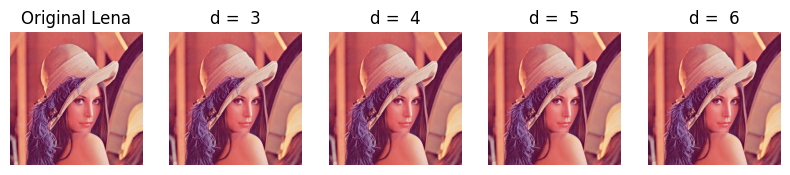

In [29]:
#Lena image

depth_list = [3, 4, 5, 6]
lena_pyramid_list2 = []
decoded_list4 = []

#Produce pyramids for each a
for depth in depth_list:
   lena_pyramid = LPyramid(lena, a=0.5, depth=depth)
   lena_pyramid_list2.append(lena_pyramid)

# Decode each pyramid with its corresponding a value
for i, pyramid in enumerate(lena_pyramid_list2):
    decoded_image = L_Pyramid_Decode(pyramid, a=0.5)
    decoded_list4.append(decoded_image)

#Plotting the images
plt.figure(figsize=(12, 12))
plt.subplot(1,len(a_list)+1,1)
plt.imshow(lena)
plt.title(f"Original Lena")
plt.axis('off')


decoded_list4_show = []
for i in range (len(decoded_list4)):
  plt.subplot(1,len(a_list)+1,i+2)
  decoded_list4_show.append(np.clip(decoded_list4[i], 0, 255).astype(np.uint8))
  plt.imshow(decoded_list4_show[i])
  plt.title(f"d =  {depth_list[i]}")
  plt.axis('off')

In [30]:
def calculate_mse(original, decoded):
    return np.mean((original - decoded) ** 2)

for i, decoded_image in enumerate(decoded_list4):
    mse = calculate_mse(lena, decoded_image)
    print(f"Για depth = {depth_list[i]}: MSE = {mse}")


Για depth = 3: MSE = 0.0
Για depth = 4: MSE = 0.0
Για depth = 5: MSE = 0.0
Για depth = 6: MSE = 0.0


# Entropy vs a - Entropy vs depth


In [ ]:
from collections import Counter
from math import log2

def H_entropy(L):
    all_entropies = []  # entropies for all levels and all values of 'a'
    # all_entropies[0] -> Entropies for all pyramid levels for a1

    for pyramid in L:
        entropy_list = []  # entropies for each level of a specific 'a'
        for level in pyramid:
            level = level.astype(np.uint8)  # convert to uint8 to ensure values are in [0, 255]
            pixels = np.array(level).flatten()

            total_pixels = len(pixels)
            counts = Counter(pixels)  # dictionary {0:13, 1:23, 2:34, ...}

            entropy = 0
            for count in counts.values():
                p = count / total_pixels
                entropy -= p * log2(p)
            entropy_list.append(entropy)

        all_entropies.append(entropy_list)

    return all_entropies


In [ ]:
a_camera_entropies = H_entropy(camera_pyramid_list1)

print("Εντροπία για την camera για μεταβλητό a:")
for i, a in enumerate(a_list): #for each a
    print(f"\nΓια a = {a}:")
    for level, entropy in enumerate(a_camera_entropies[i]): #for each pyramid level
        print(f"  Επίπεδο {level}: H = {entropy}")



Εντροπία για την camera για μεταβλητό a:

Για a = 0.3:
  Επίπεδο 0: H = 4.304980938075515
  Επίπεδο 1: H = 4.073345440867843
  Επίπεδο 2: H = 4.434602975017135
  Επίπεδο 3: H = 5.080687803632257
  Επίπεδο 4: H = 5.996383427106868
  Επίπεδο 5: H = 6.4976652112123565

Για a = 0.4:
  Επίπεδο 0: H = 4.130697124598416
  Επίπεδο 1: H = 3.982246543004795
  Επίπεδο 2: H = 4.343874914400907
  Επίπεδο 3: H = 4.9026614663850205
  Επίπεδο 4: H = 5.799418837526641
  Επίπεδο 5: H = 6.48866613885377

Για a = 0.5:
  Επίπεδο 0: H = 3.8510885023636314
  Επίπεδο 1: H = 3.7721804178575624
  Επίπεδο 2: H = 4.098995991028763
  Επίπεδο 3: H = 4.553873029660072
  Επίπεδο 4: H = 5.295714786576564
  Επίπεδο 5: H = 6.481497377277131

Για a = 0.6:
  Επίπεδο 0: H = 3.734813883221914
  Επίπεδο 1: H = 3.9497260212965126
  Επίπεδο 2: H = 4.4249920404690934
  Επίπεδο 3: H = 5.025119527626925
  Επίπεδο 4: H = 5.769634277614134
  Επίπεδο 5: H = 6.543053725245154

Για a = 0.7:
  Επίπεδο 0: H = 4.069949044170461
  Επίπεδο

In [ ]:
depth_camera_entropies = H_entropy(camera_pyramid_list2)

print("Εντροπία για την camera για μεταβλητό depth:")
for i, depth in enumerate(depth_list):
    print(f"\nΓια depth = {depth}:")
    for level, entropy in enumerate(depth_camera_entropies[i]):
        print(f"  Επίπεδο {level}: H = {entropy}")


Εντροπία για την camera για μεταβλητό depth:

Για depth = 3:
  Επίπεδο 0: H = 3.8510885023636314
  Επίπεδο 1: H = 3.7721804178575624
  Επίπεδο 2: H = 4.098995991028763
  Επίπεδο 3: H = 6.95369506217862

Για depth = 4:
  Επίπεδο 0: H = 3.8510885023636314
  Επίπεδο 1: H = 3.7721804178575624
  Επίπεδο 2: H = 4.098995991028763
  Επίπεδο 3: H = 4.553873029660072
  Επίπεδο 4: H = 6.865262085037909

Για depth = 5:
  Επίπεδο 0: H = 3.8510885023636314
  Επίπεδο 1: H = 3.7721804178575624
  Επίπεδο 2: H = 4.098995991028763
  Επίπεδο 3: H = 4.553873029660072
  Επίπεδο 4: H = 5.295714786576564
  Επίπεδο 5: H = 6.481497377277131

Για depth = 6:
  Επίπεδο 0: H = 3.8510885023636314
  Επίπεδο 1: H = 3.7721804178575624
  Επίπεδο 2: H = 4.098995991028763
  Επίπεδο 3: H = 4.553873029660072
  Επίπεδο 4: H = 5.295714786576564
  Επίπεδο 5: H = 6.047609867560086
  Επίπεδο 6: H = 5.507659765557392


In [ ]:
a_lena_entropies = H_entropy(lena_pyramid_list1)

print("Εντροπία για την lena για μεταβλητό a:")
for i, a in enumerate(a_list):
    print(f"\nΓια a = {a}:")
    for level, entropy in enumerate(a_lena_entropies[i]):
        print(f"  Επίπεδο {level}: H = {entropy}")


Εντροπία για την lena για μεταβλητό a:

Για a = 0.3:
  Επίπεδο 0: H = 4.7293859246531404
  Επίπεδο 1: H = 4.499819554153762
  Επίπεδο 2: H = 5.252249651629225
  Επίπεδο 3: H = 6.016785034102785
  Επίπεδο 4: H = 6.517826925284172
  Επίπεδο 5: H = 7.124504534941515

Για a = 0.4:
  Επίπεδο 0: H = 4.5526529531557305
  Επίπεδο 1: H = 4.3445330984839226
  Επίπεδο 2: H = 5.046484289986899
  Επίπεδο 3: H = 5.863792121869862
  Επίπεδο 4: H = 6.457072018996786
  Επίπεδο 5: H = 7.170697157456761

Για a = 0.5:
  Επίπεδο 0: H = 4.288530461881309
  Επίπεδο 1: H = 4.0925296666933
  Επίπεδο 2: H = 4.67538900142104
  Επίπεδο 3: H = 5.555578388598228
  Επίπεδο 4: H = 6.355559088851885
  Επίπεδο 5: H = 7.233910574173556

Για a = 0.6:
  Επίπεδο 0: H = 4.1352788461645495
  Επίπεδο 1: H = 4.254191627659668
  Επίπεδο 2: H = 4.8971751343292595
  Επίπεδο 3: H = 5.781097354707909
  Επίπεδο 4: H = 6.600405041477135
  Επίπεδο 5: H = 7.286005986181785

Για a = 0.7:
  Επίπεδο 0: H = 4.491292003054478
  Επίπεδο 1: H

In [ ]:
depth_lena_entropies = H_entropy(lena_pyramid_list2)

print("Εντροπία για την lena για μεταβλητό depth:")
for i, depth in enumerate(depth_list):
    print(f"\nΓια depth = {depth}:")
    for level_idx, entropy in enumerate(depth_lena_entropies[i]):
        print(f"  Επίπεδο {level_idx}: H = {entropy}")


Εντροπία για την lena για μεταβλητό depth:

Για depth = 3:
  Επίπεδο 0: H = 4.288530461881309
  Επίπεδο 1: H = 4.0925296666933
  Επίπεδο 2: H = 4.67538900142104
  Επίπεδο 3: H = 7.635959683642114

Για depth = 4:
  Επίπεδο 0: H = 4.288530461881309
  Επίπεδο 1: H = 4.0925296666933
  Επίπεδο 2: H = 4.67538900142104
  Επίπεδο 3: H = 5.555578388598228
  Επίπεδο 4: H = 7.526066079704161

Για depth = 5:
  Επίπεδο 0: H = 4.288530461881309
  Επίπεδο 1: H = 4.0925296666933
  Επίπεδο 2: H = 4.67538900142104
  Επίπεδο 3: H = 5.555578388598228
  Επίπεδο 4: H = 6.355559088851885
  Επίπεδο 5: H = 7.233910574173556

Για depth = 6:
  Επίπεδο 0: H = 4.288530461881309
  Επίπεδο 1: H = 4.0925296666933
  Επίπεδο 2: H = 4.67538900142104
  Επίπεδο 3: H = 5.555578388598228
  Επίπεδο 4: H = 6.355559088851885
  Επίπεδο 5: H = 6.7317625985550436
  Επίπεδο 6: H = 6.52991862035508


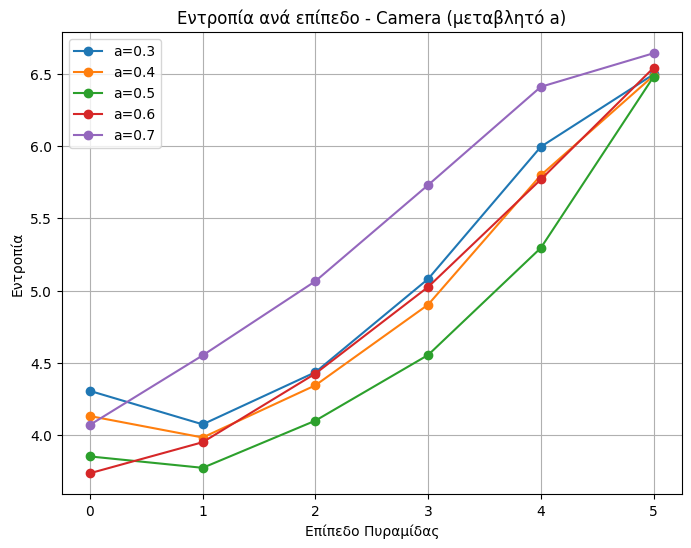

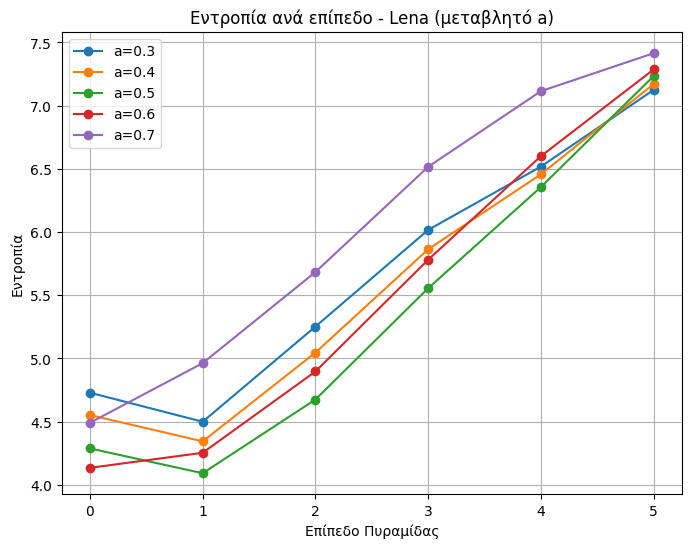

In [ ]:
def plot_entropy_vs_levels(entropies_list, label_list, title):
    plt.figure(figsize=(8,6))
    for i, entropies in enumerate(entropies_list):
        plt.plot(range(len(entropies)), entropies, marker='o', label=f"{label_list[i]}")
    plt.xlabel("Pyramid Level")
    plt.ylabel("Entropy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example for varying a (camera)
plot_entropy_vs_levels(a_camera_entropies, [f"a={a}" for a in a_list], "Entropy per Level - Camera (varying a)")

# Example for varying a (lena)
plot_entropy_vs_levels(a_lena_entropies, [f"a={a}" for a in a_list], "Entropy per Level - Lena (varying a)")


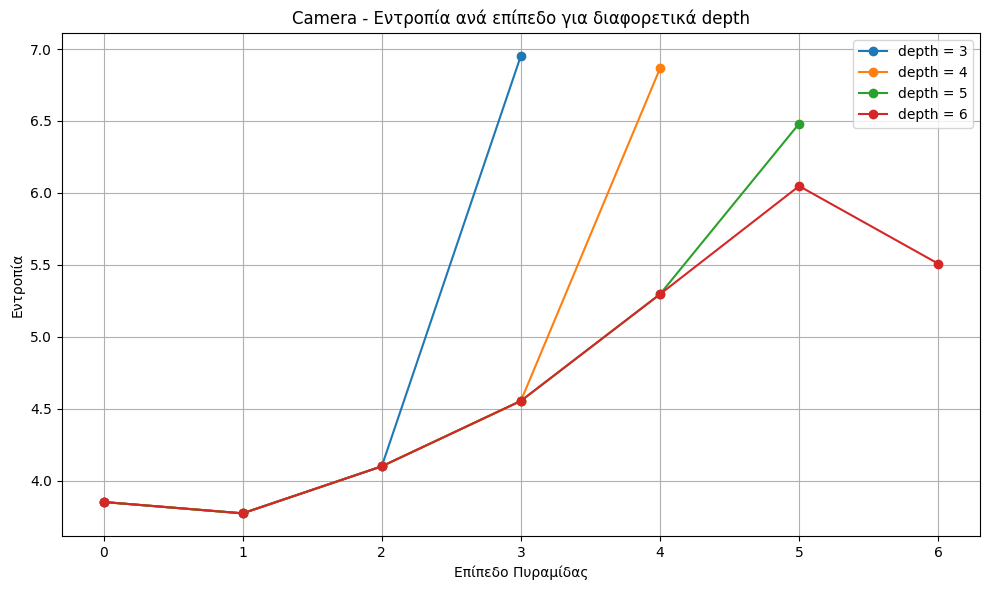

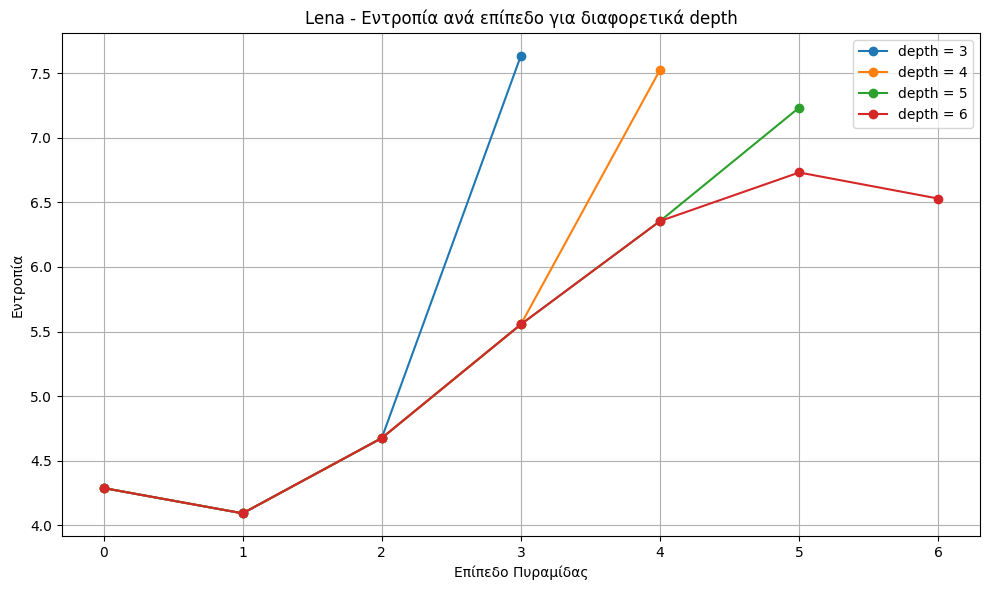

In [ ]:
#Διαγραμματα για μεταβλητό depth

def plot_entropy_vs_levels(entropy_lists, labels, title):
    plt.figure(figsize=(10, 6))
    for entropies, label in zip(entropy_lists, labels):
        levels = list(range(len(entropies)))
        plt.plot(levels, entropies, marker='o', label=label)
    plt.xlabel("Επίπεδο Πυραμίδας")
    plt.ylabel("Εντροπία")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_entropy_vs_levels(
    entropy_lists=depth_camera_entropies,
    labels=[f"depth = {d}" for d in depth_list],
    title="Camera - Εντροπία ανά επίπεδο για διαφορετικά depth"
)



plot_entropy_vs_levels(
    entropy_lists=depth_lena_entropies,
    labels=[f"depth = {d}" for d in depth_list],
    title="Lena - Εντροπία ανά επίπεδο για διαφορετικά depth"
)




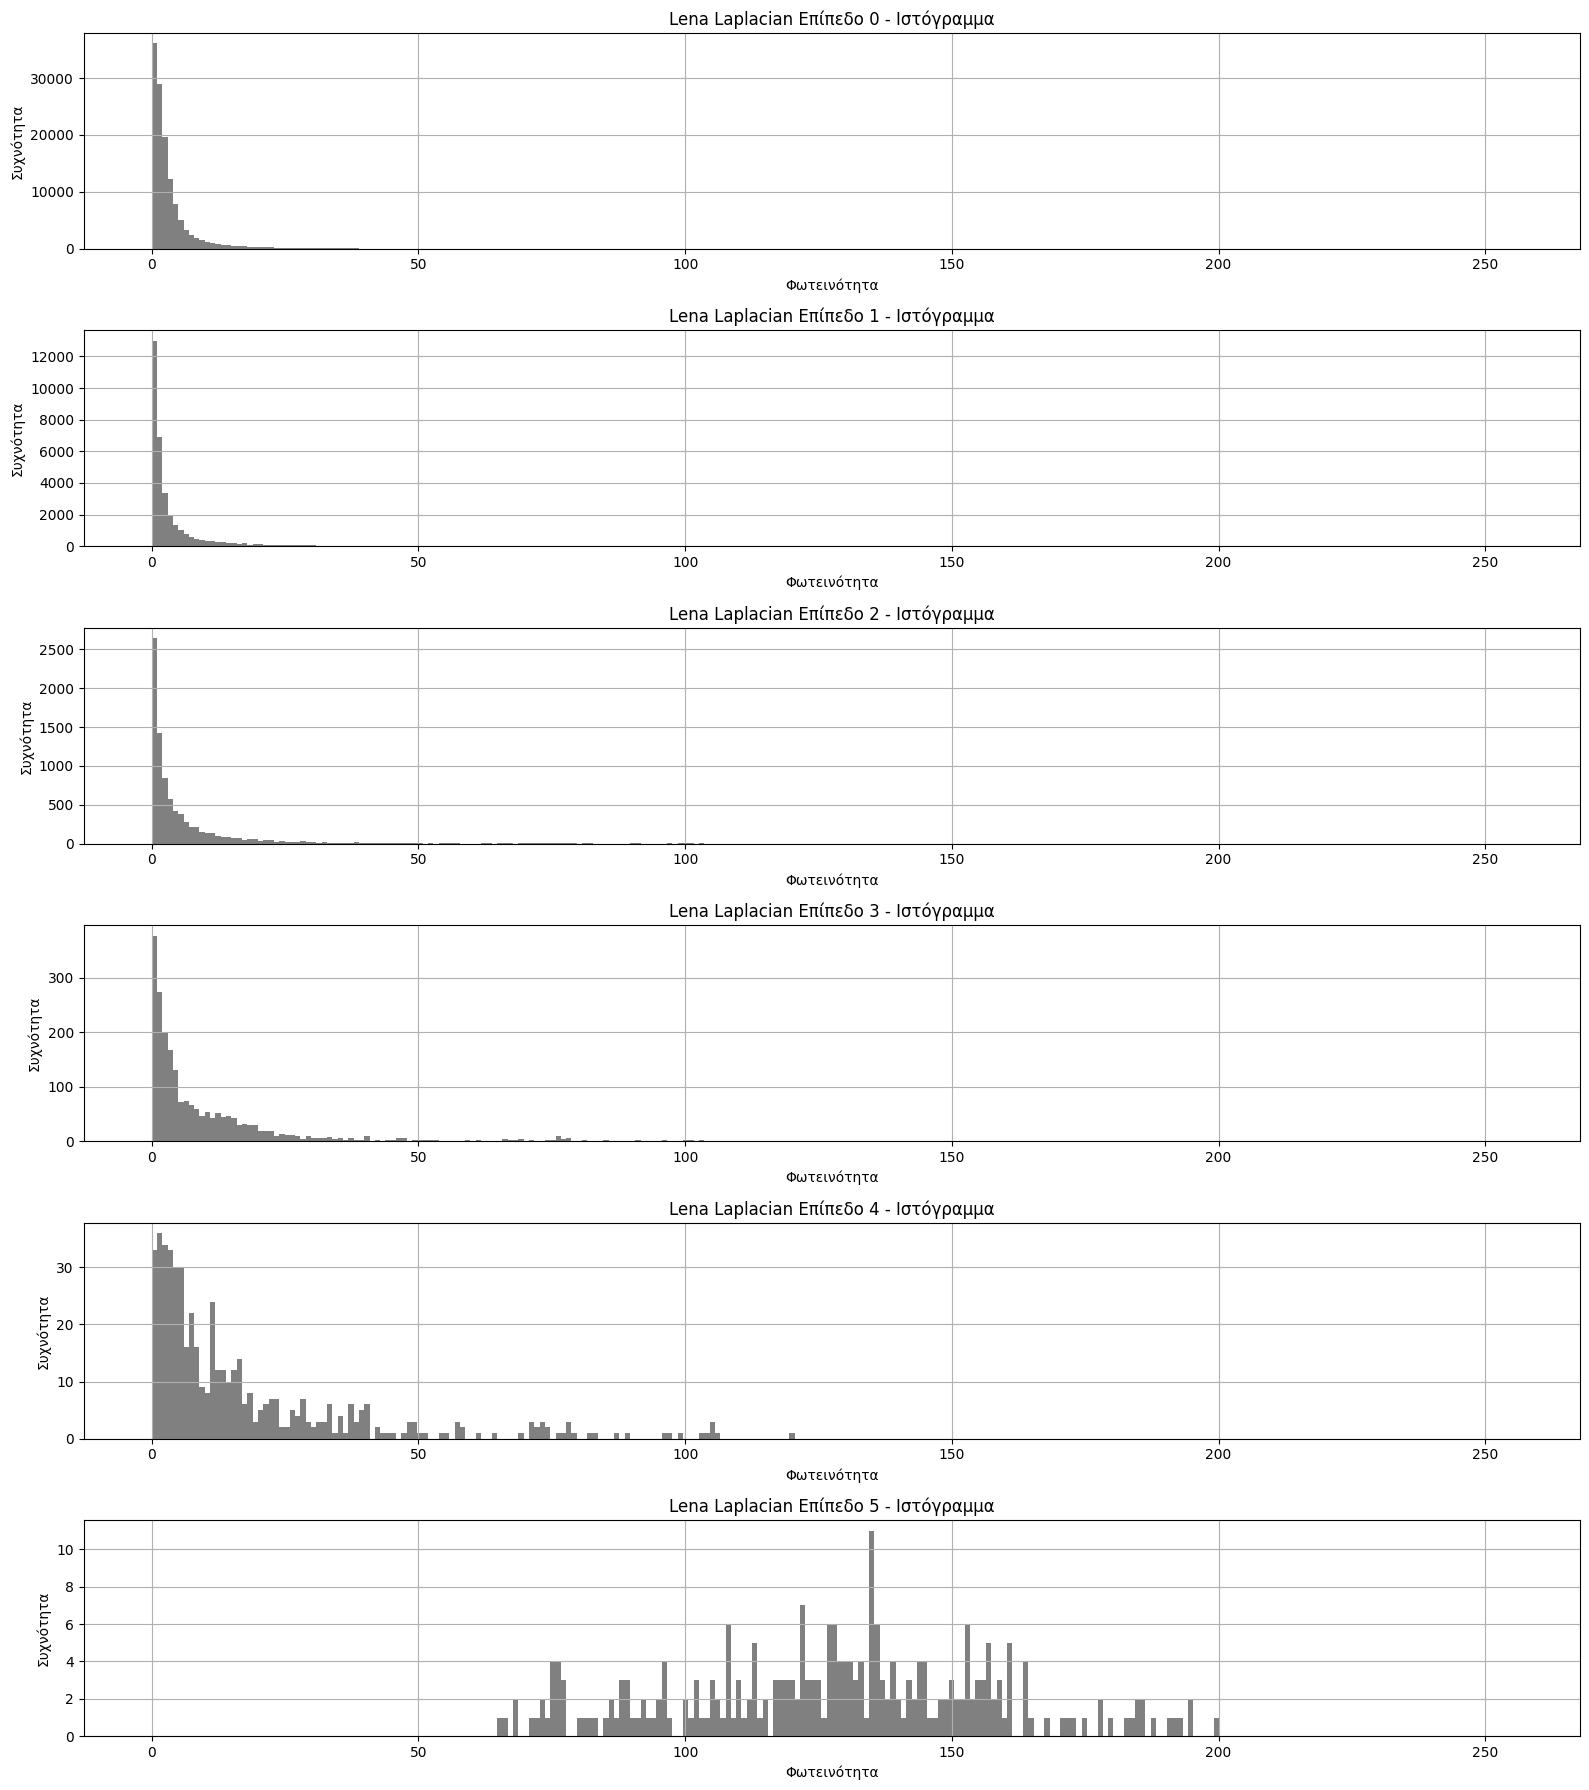

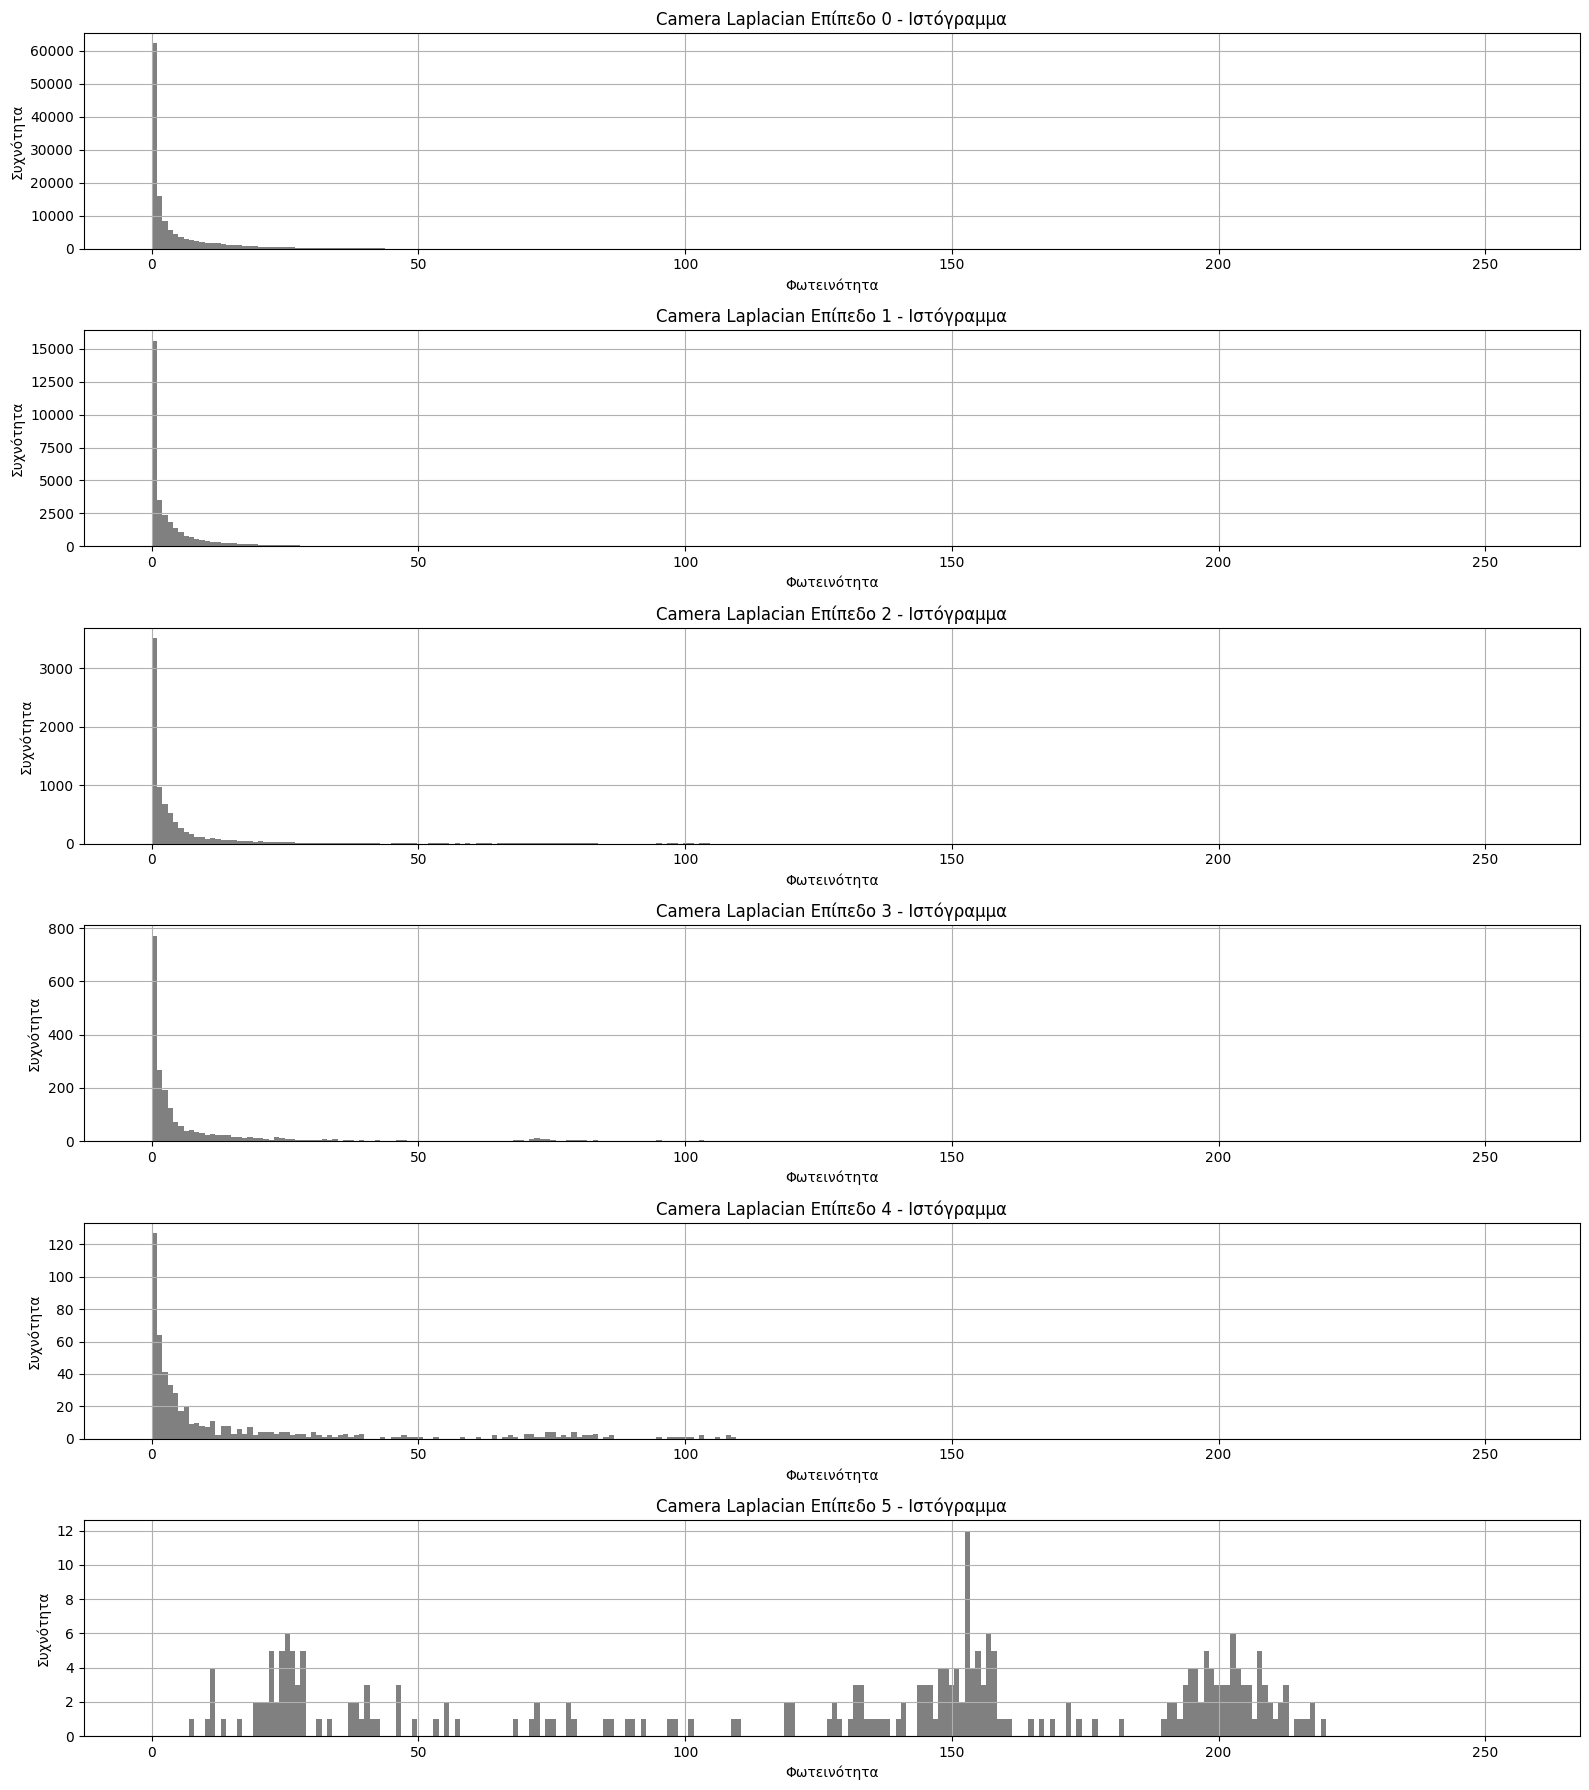

In [ ]:
def plot_histograms_for_pyramid(pyramid, title_prefix=""):
    num_levels = len(pyramid)
    plt.figure(figsize=(16, 3 * num_levels))

    for i, level in enumerate(pyramid):
        plt.subplot(num_levels, 1, i + 1)

        # If it is a color image -> compute histogram per channel or convert to grayscale
        if level.ndim == 3:
            level_gray = np.mean(level, axis=2)  # or use np.dot for more accurate luminance
        else:
            level_gray = level

        # Flatten and display histogram
        plt.hist(level_gray.ravel(), bins=256, range=(0, 255), color='gray')
        plt.title(f"{title_prefix} Level {i} - Histogram")
        plt.xlabel("Brightness")
        plt.ylabel("Frequency")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# For lena or camera
plot_histograms_for_pyramid(lena_laplacian_pyramid, title_prefix="Lena Laplacian")
plot_histograms_for_pyramid(camera_laplacian_pyramid, title_prefix="Camera Laplacian")


# **Conclusions**

1) The depth does not significantly affect the entropy between the same levels of the pyramid. However, it is observed that as the pyramid becomes "deeper", the entropy of the last level decreases.

2) As the pyramid level increases, the entropy also increases, since more detail/information is retained and therefore the uncertainty about the value of a pixel becomes greater.


In [ ]:
print("Camera: \n")

##best a for level 0 (less entropy)
list0 = []
for i in range(5):
  list0.append(a_camera_entropies[i][0])

best_entropy = min(list0)
best_entropy_index = list0.index(best_entropy)
print(f"Best entropy for level 0: {best_entropy} for a = {a_list[best_entropy_index]}")


##best a for level 1 (less entropy)
list1 = []
for i in range(5):
  list1.append(a_camera_entropies[i][1])

best_entropy = min(list1)
best_entropy_index = list1.index(best_entropy)
print(f"Best entropy for level 1: {best_entropy} for a = {a_list[best_entropy_index]}")


##best a for level 2 (less entropy)
list2 = []
for i in range(5):
  list2.append(a_camera_entropies[i][2])

best_entropy = min(list2)
best_entropy_index = list2.index(best_entropy)
print(f"Best entropy for level 2: {best_entropy} for a = {a_list[best_entropy_index]}")


##best a for level 3(less entropy)
list3 = []
for i in range(5):
  list3.append(a_camera_entropies[i][3])

best_entropy = min(list3)
best_entropy_index = list3.index(best_entropy)
print(f"Best entropy for level 3: {best_entropy} for a = {a_list[best_entropy_index]}")




##best a for level 4 (less entropy)
list4 = []
for i in range(5):
  list4.append(a_camera_entropies[i][4])

best_entropy = min(list4)
best_entropy_index = list4.index(best_entropy)
print(f"Best entropy for level 4: {best_entropy} for a = {a_list[best_entropy_index]}")


##best a for level 5 (less entropy)
list5 = []
for i in range(5):
  list5.append(a_camera_entropies[i][5])

best_entropy = min(list5)
best_entropy_index = list5.index(best_entropy)
print(f"Best entropy for level 5: {best_entropy} for a = {a_list[best_entropy_index]}")




Camera: 

Best entropy for level 0: 3.734813883221914 for a = 0.6
Best entropy for level 1: 3.7721804178575624 for a = 0.5
Best entropy for level 2: 4.098995991028763 for a = 0.5
Best entropy for level 3: 4.553873029660072 for a = 0.5
Best entropy for level 4: 5.295714786576564 for a = 0.5
Best entropy for level 5: 6.481497377277131 for a = 0.5


As shown in the diagrams and from the printed values above, we conclude that most levels of the pyramid reach their lowest entropy when a = 0.5 for the camera image.


In [ ]:
print("Lena: \n")

##best a for level 0 (less entropy)
list0 = []
for i in range(5):
  list0.append(a_lena_entropies[i][0])

best_entropy = min(list0)
best_entropy_index = list0.index(best_entropy)
print(f"Best entropy for level 0: {best_entropy} for a = {a_list[best_entropy_index]}")


##best a for level 1 (less entropy)
list1 = []
for i in range(5):
  list1.append(a_lena_entropies[i][1])

best_entropy = min(list1)
best_entropy_index = list1.index(best_entropy)
print(f"Best entropy for level 1: {best_entropy} for a = {a_list[best_entropy_index]}")


##best a for level 2 (less entropy)
list2 = []
for i in range(5):
  list2.append(a_lena_entropies[i][2])

best_entropy = min(list2)
best_entropy_index = list2.index(best_entropy)
print(f"Best entropy for level 2: {best_entropy} for a = {a_list[best_entropy_index]}")


##best a for level 3(less entropy)
list3 = []
for i in range(5):
  list3.append(a_lena_entropies[i][3])

best_entropy = min(list3)
best_entropy_index = list3.index(best_entropy)
print(f"Best entropy for level 3: {best_entropy} for a = {a_list[best_entropy_index]}")




##best a for level 4 (less entropy)
list4 = []
for i in range(5):
  list4.append(a_lena_entropies[i][4])

best_entropy = min(list4)
best_entropy_index = list4.index(best_entropy)
print(f"Best entropy for level 4: {best_entropy} for a = {a_list[best_entropy_index]}")


##best a for level 5 (less entropy)
list5 = []
for i in range(5):
  list5.append(a_lena_entropies[i][5])

best_entropy = min(list5)
best_entropy_index = list5.index(best_entropy)
print(f"Best entropy for level 5: {best_entropy} for a = {a_list[best_entropy_index]}")




Lena: 

Best entropy for level 0: 4.1352788461645495 for a = 0.6
Best entropy for level 1: 4.0925296666933 for a = 0.5
Best entropy for level 2: 4.67538900142104 for a = 0.5
Best entropy for level 3: 5.555578388598228 for a = 0.5
Best entropy for level 4: 6.355559088851885 for a = 0.5
Best entropy for level 5: 7.124504534941515 for a = 0.3


We therefore conclude that most levels of the pyramid achieve their lowest entropy at a = 0.5 in the camera image.


**Continuing by selecting a = 0.5**, we will quantize the images using different bin sizes (n).


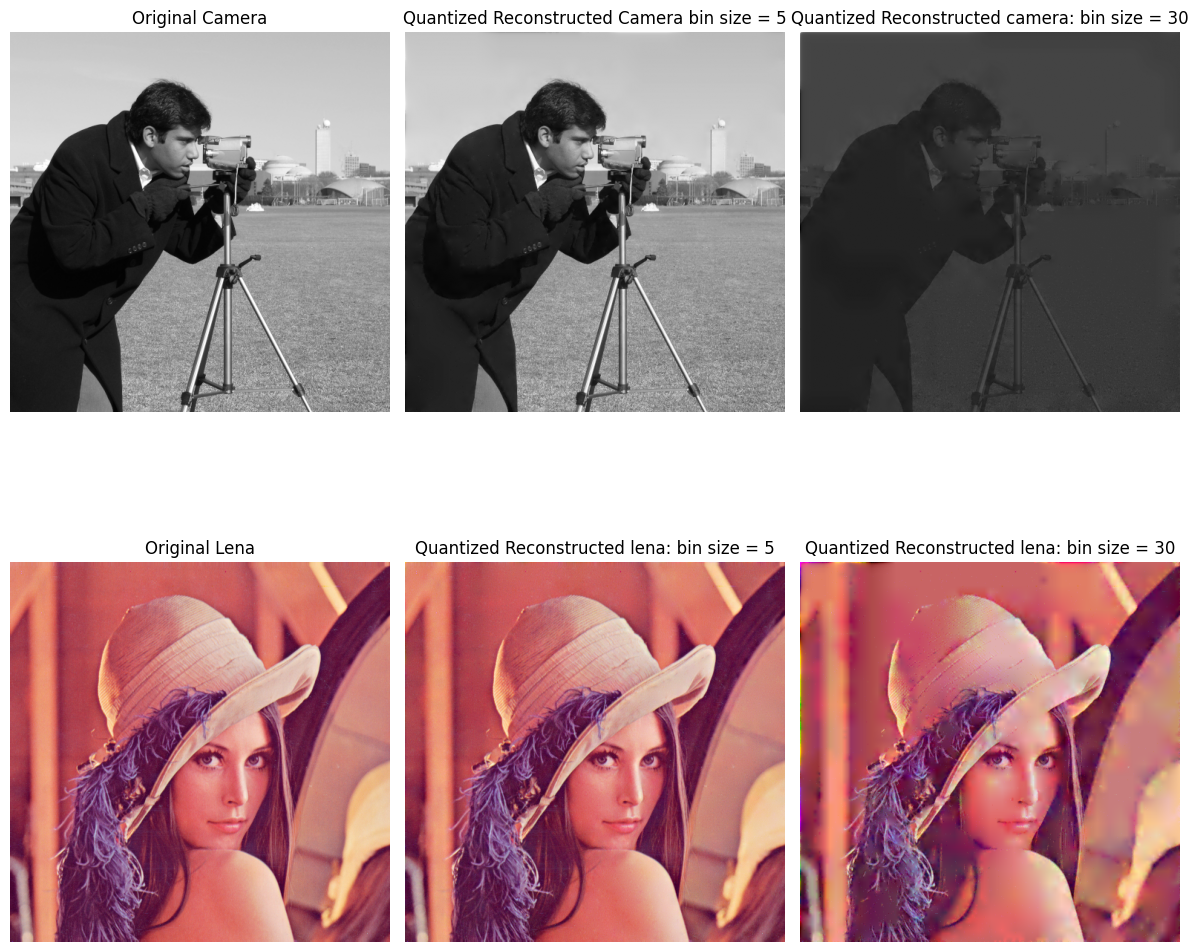

In [32]:
#laplacian pyramids of images
camera_laplacian_pyramid = LPyramid(camera, a=0.5, depth=5)
lena_laplacian_pyramid = LPyramid(lena, a=0.5, depth=5)

#Quantized images for bin sizes n=5,25
quantized_camera_laplacian_pyramid_5 = L_Quantization(camera_laplacian_pyramid, n=5)
quantized_camera_laplacian_pyramid_25 = L_Quantization(camera_laplacian_pyramid, n=30)

quantized_lena_laplacian_pyramid_5 = L_Quantization(lena_laplacian_pyramid, n=5)
quantized_lena_laplacian_pyramid_25 = L_Quantization(lena_laplacian_pyramid, n=25)




#reconstructed images
reconstructed_camera_5 = L_Pyramid_Decode(quantized_camera_laplacian_pyramid_5, a=0.5)
reconstructed_camera_25 = L_Pyramid_Decode(quantized_camera_laplacian_pyramid_25, a=0.5)
reconstructed_lena_5 = L_Pyramid_Decode(quantized_lena_laplacian_pyramid_5, a=0.5)
reconstructed_lena_25 = L_Pyramid_Decode(quantized_lena_laplacian_pyramid_25, a=0.5)



plt.figure(figsize=(12, 12))

plt.subplot(2, 3, 1)
plt.imshow(camera, cmap='gray')
plt.title("Original Camera")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(reconstructed_camera_5, cmap='gray')
plt.title("Quantized Reconstructed Camera bin size = 5")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(reconstructed_camera_25, cmap='gray')
plt.title("Quantized Reconstructed camera: bin size = 30")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(lena)
plt.title("Original Lena")
plt.axis('off')

plt.subplot(2, 3, 5)
reconstructed_lena_5_show = np.clip(reconstructed_lena_5, 0, 255).astype(np.uint8)
plt.imshow(reconstructed_lena_5_show)
plt.title("Quantized Reconstructed lena: bin size = 5")
plt.axis('off')

plt.subplot(2, 3, 6)
reconstructed_lena_25_show = np.clip(reconstructed_lena_25, 0, 255).astype(np.uint8)
plt.imshow(reconstructed_lena_25_show)
plt.title("Quantized Reconstructed lena: bin size = 30")
plt.axis('off')

plt.tight_layout()
plt.show()


In [35]:
from collections import Counter
from math import log2
import numpy as np

def image_entropy(image):

    image = image.astype(np.uint8)
    pixels = image.flatten()
    total_pixels = len(pixels)
    counts = Counter(pixels)

    entropy = 0
    for count in counts.values():
        p = count / total_pixels
        entropy -= p * log2(p)

    return entropy


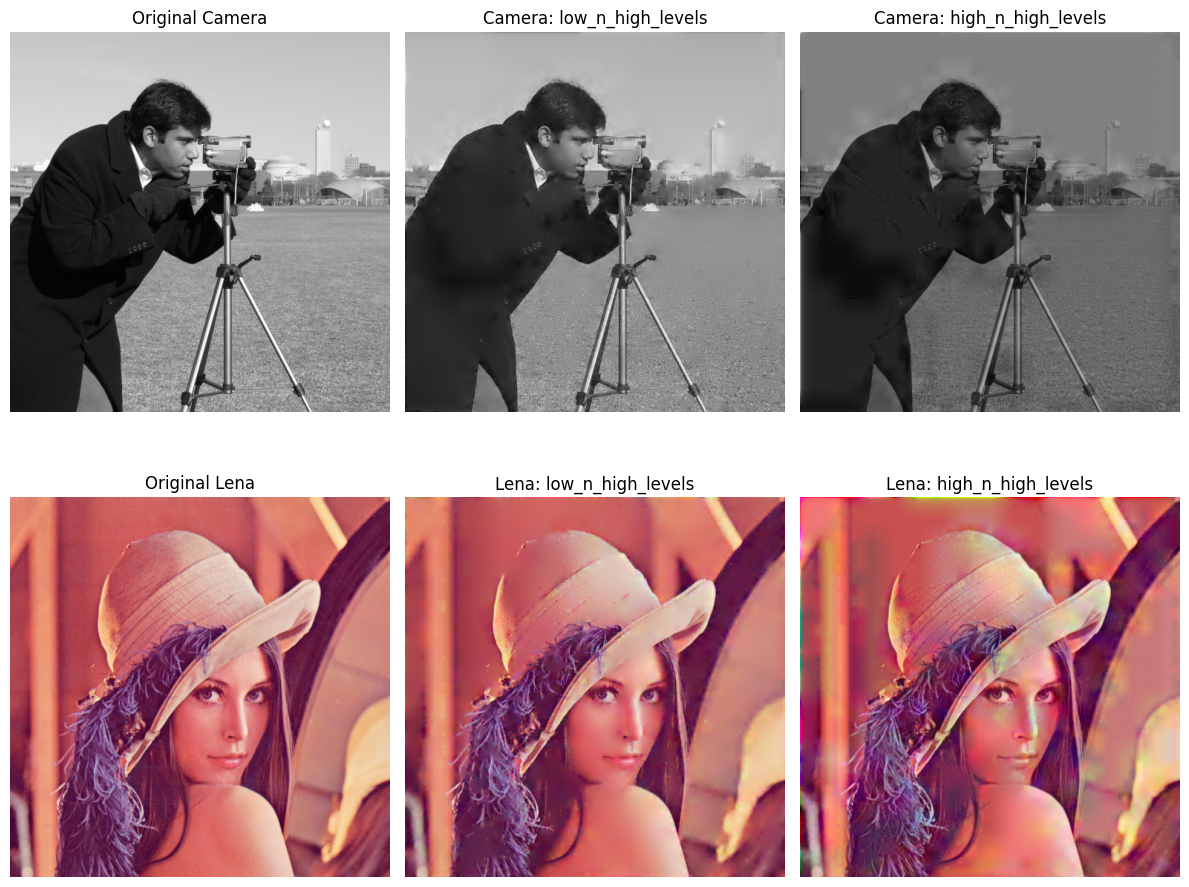

---- Εντροπία Camera ----
Original Camera: 7.2317
Reconstructed (low_n_high_levels): 7.1432
Reconstructed (high_n_high_levels): 6.5316

---- Εντροπία Lena ----
Original Lena: 7.7503
Reconstructed (low_n_high_levels): 7.7122
Reconstructed (high_n_high_levels): 7.5926


In [ ]:
# We assume depth = 6 (levels 0 to 5), i.e., 6 levels in the pyramid
low_n_high_levels = [30, 25, 20, 15, 10, 5]     # More detail in coarse levels
high_n_high_levels = [5, 10, 15, 30, 35, 40]    # Less detail in coarse levels

# Create Laplacian pyramids
camera_L = LPyramid(camera, a=0.5, depth=5)
lena_L = LPyramid(lena, a=0.5, depth=5)

# Quantization with varying bin sizes
camera_q_A = L_Quantization(camera_L, low_n_high_levels)
camera_q_B = L_Quantization(camera_L, high_n_high_levels)
lena_q_A = L_Quantization(lena_L, low_n_high_levels)
lena_q_B = L_Quantization(lena_L, high_n_high_levels)

# Reconstruct images
camera_r_A = L_Pyramid_Decode(camera_q_A, a=0.5)
camera_r_B = L_Pyramid_Decode(camera_q_B, a=0.5)
lena_r_A = L_Pyramid_Decode(lena_q_A, a=0.5)
lena_r_B = L_Pyramid_Decode(lena_q_B, a=0.5)

# Display results
plt.figure(figsize=(12, 10))

plt.subplot(2, 3, 1)
plt.imshow(camera, cmap='gray')
plt.title("Original Camera")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(camera_r_A, cmap='gray')
plt.title("Camera: low_n_high_levels")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(camera_r_B, cmap='gray')
plt.title("Camera: high_n_high_levels")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(lena.astype(np.uint8))
plt.title("Original Lena")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(np.clip(lena_r_A, 0, 255).astype(np.uint8))
plt.title("Lena: low_n_high_levels")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(np.clip(lena_r_B, 0, 255).astype(np.uint8))
plt.title("Lena: high_n_high_levels")
plt.axis('off')

plt.tight_layout()
plt.show()

# Entropy
print("---- Camera Entropy ----")
print(f"Original Camera: {image_entropy(camera):.4f}")
print(f"Reconstructed (low_n_high_levels): {image_entropy(camera_r_A):.4f}")
print(f"Reconstructed (high_n_high_levels): {image_entropy(camera_r_B):.4f}")

print("\n---- Lena Entropy ----")
print(f"Original Lena: {image_entropy(lena):.4f}")
print(f"Reconstructed (low_n_high_levels): {image_entropy(lena_r_A):.4f}")
print(f"Reconstructed (high_n_high_levels): {image_entropy(lena_r_B):.4f}")


We observe that for both the Camera and Lena images, the quantized version has—as expected—lower entropy, since the number of unique pixel values is reduced. In one experiment, we used large bin sizes for the low levels and small bin sizes for the high levels of the pyramid. In the second experiment, we did the opposite.

We conclude that using smaller bin sizes at higher pyramid levels yields better visual results. This is because the higher levels contain lower spatial frequencies, which are more perceptible to the human eye, and we want to preserve that information. On the other hand, using large bin sizes at high levels results in more visually distorted images.

Additionally, quantization in general reduces entropy—and therefore bits per pixel—as bin sizes increase. However, there must be a balance: we want to compress the image efficiently without significantly degrading its visual quality.
